(pratica_isostasia)=
# Prática 2: Isostasia, flexura e gravidade

```{admonition} Objetivos
:class: important

1. bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
1. bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
1. bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
1. bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla bla
```

```{admonition} Antes de começar
:class: seealso

Esta prática depende do conteúdo das aulas:

* {ref}`litosfera`
* {ref}`gravidade`
* {ref}`isostasia`
* {ref}`pratica_grav`
```

## Bibliotecas

Vamos primeiro carregar as bibliotecas que vamos utilizar nessa prática.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xrft
import harmonica as hm
import verde as vd
import pyproj
import pygmt

## Dados

Nesta prática, vamos utilizar os dados de distúrbio da gravidade, anomalia Bouguer simples e topografia que compilamos na prática passada.

In [2]:
dados = xr.load_dataset("dados.nc")
dados

<xarray.Dataset>
Dimensions:     (longitude: 2161, latitude: 1081)
Coordinates:
  * longitude   (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude    (latitude) float64 -90.0 -89.83 -89.67 ... 89.67 89.83 90.0
    height      (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04
Data variables:
    gravidade   (latitude, longitude) float32 9.801e+05 9.801e+05 ... 9.802e+05
    disturbio   (latitude, longitude) float64 -35.84 -35.84 ... 15.16 15.16
    topografia  (latitude, longitude) float32 2.742e+03 2.742e+03 ... -4.237e+03
    bouguer     (latitude, longitude) float64 -339.5 -339.5 ... 303.7 303.7

## Bouguer vs topografia

Como vimos na aula teórica, nos casos em que há compensação isostática segundo o modelo de Airy esperamos que a anomalia Bouguer possua uma **relação linear** com a topografia. Vamos verificar se isso é verdade para a Terra como um todo utilizando nossos dados.

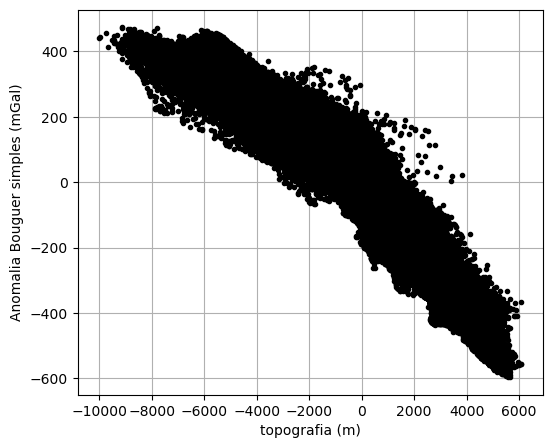

In [3]:
plt.figure(figsize=(6, 5))
plt.plot(dados.topografia.values.ravel(), dados.bouguer.values.ravel(), ".k")
plt.xlabel("topografia (m)")
plt.ylabel("Anomalia Bouguer simples (mGal)")
plt.grid()

A princípio parece que sim! Vamos calcular o valor teórico predito para ser se nosso modelo se ajusta aos dados.

In [4]:
def bouguer_airy(topografia, densidade_crosta_continental, densidade_crosta_oceanica, densidade_agua):
    """
    Calcula a anomalia Bouguer prevista por um modelo de Airy.
    """
    G = 6.67430e-11
    bouguer = xr.where(
        topografia >= 0,
        1e5 * -2 * np.pi * G * densidade_crosta_continental * topografia,
        1e5 * -2 * np.pi * G * (densidade_crosta_oceanica - densidade_agua) * topografia,
    )
    return bouguer

In [5]:
previsto = bouguer_airy(
    dados.topografia, 
    densidade_crosta_continental=2700, 
    densidade_crosta_oceanica=2800, 
    densidade_agua=1000,
)

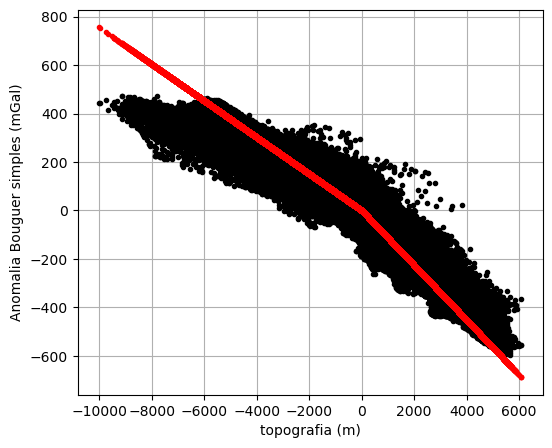

In [6]:
plt.figure(figsize=(6, 5))
plt.plot(dados.topografia.values.ravel(), dados.bouguer.values.ravel(), ".k")
plt.plot(dados.topografia.values.ravel(), previsto.values.ravel(), ".r")
plt.xlabel("topografia (m)")
plt.ylabel("Anomalia Bouguer simples (mGal)")
plt.grid()

:::{admonition} 💬 **Discussão**
:class: tip

Com base na figura acima 👆🏽, discuta em grupos de 2-3:

1. Quais ambientes tectônicos são responsáveis pelo desajuste no canto superior esquerdo e inferior direito da figura? 
1. Qual é uma possível explicação geofísica/tectônica para esse desajuste?

:::

::::{admonition} 🧘 **Sua vez: O que acontece nas dorsais?** 
:class: tip

As dorsais estão em equilíbrio isostático, como vimos no mapa do distúrbio da gravidade na aula passada. Porém, o modelo Airy não é adequado para explicar a compensação isostática das dorsais.

1. Qual modelo de compensação explica o equilíbrio nas dorsais?
1. Derive a relação entre topografia e anomalia Bouguer para esse modelo e a implemente em uma função.
1. Selecione uma parcela dos dados que contém uma dorsal e aplique seu modelo.
1. O modelo ajusta os dados? Como esse modelo difere da previsão utilizando Airy?

::::

## Flexura da litosfera oceânica

In [7]:
havai = dados.sel(longitude=slice(-180, -150), latitude=slice(15, 30))

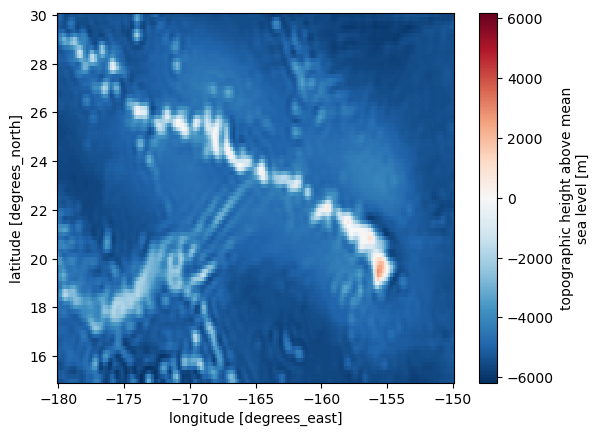

In [8]:
havai.topografia.plot()

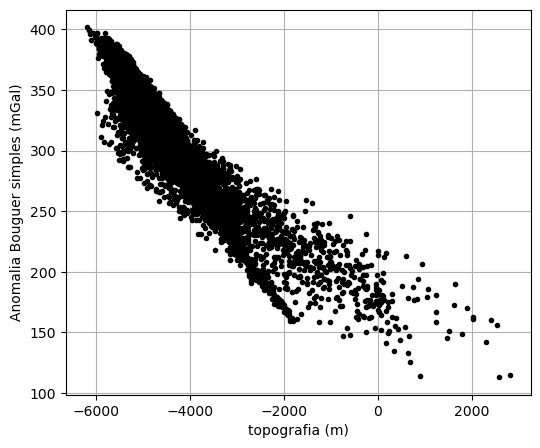

In [9]:
plt.figure(figsize=(6, 5))
plt.plot(havai.topografia.values.ravel(), havai.bouguer.values.ravel(), ".k")
plt.xlabel("topografia (m)")
plt.ylabel("Anomalia Bouguer simples (mGal)")
plt.grid()

In [10]:
merc = pyproj.Proj(proj="merc")
topografia = vd.project_grid(havai.topografia, merc, method="nearest")
disturbio = vd.project_grid(havai.disturbio, merc, method="nearest")

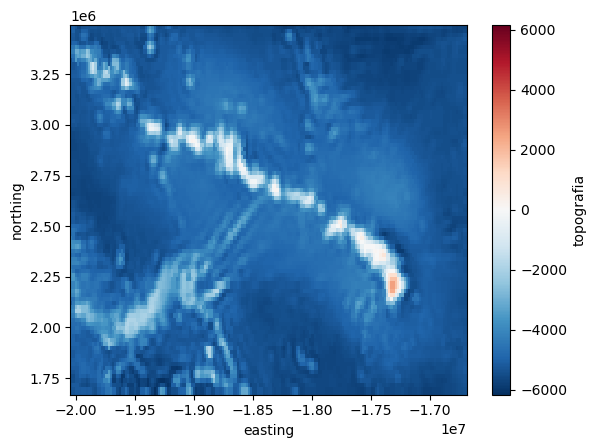

In [11]:
topografia.plot()

$$
W(k_x, k_y) = \dfrac{-(\rho_c - \rho_w)}{(\rho_m - \rho_c)}\left[1 + \dfrac{D(2\pi k)^4}{g(\rho_m - \rho_c)}\right]^{-1} T(k_x, k_y)
$$

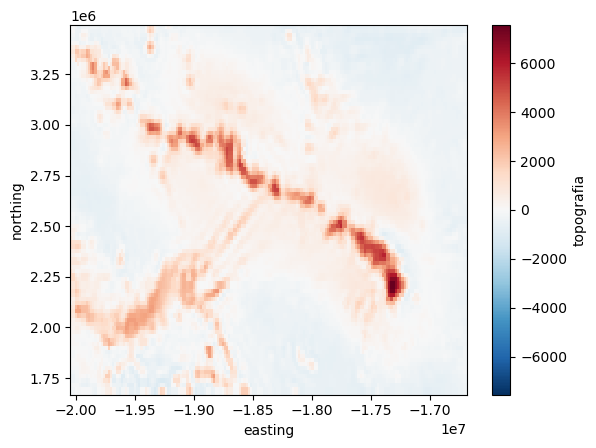

In [12]:
s = np.median(topografia)
topografia_residual = topografia - s
topografia_residual.plot()

/home/leo/bin/conda/envs/aula2023/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


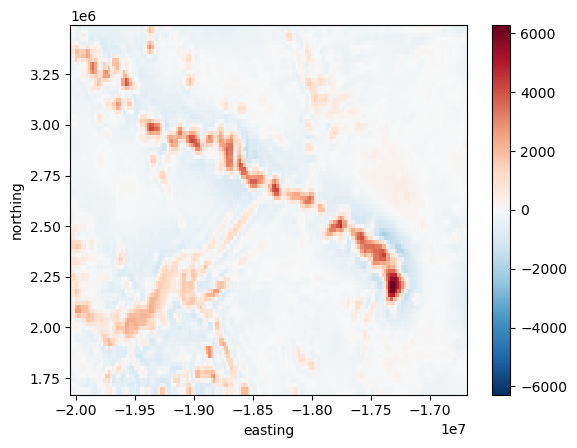

In [13]:
topografia_residual = hm.gaussian_highpass(topografia_residual, wavelength=1e6)
topografia_residual.plot()

In [14]:
topografia_ft = xrft.fft(topografia_residual, true_amplitude=True, true_phase=True)

In [17]:
def filtro_flexura(
    kx, ky, Te, densidade_crosta=2800, densidade_agua=1000, densidade_manto=3300, 
    young=6.5e10, poisson=0.25, gravidade=9.8,
):
    """
    Calcula o filtro da flexura no domínio da frequência.
    """
    D = young * Te ** 3 / (
        12 * (1 - poisson ** 2)
    )
    k = np.sqrt(ky**2 + kx**2)
    filtro = (
        -(densidade_crosta - densidade_agua) 
        / (densidade_manto - densidade_crosta) 
        * 1 / (
            1 + (D * (2 * np.pi * k)**4)
            / (gravidade * (densidade_manto - densidade_crosta))
        )
    )
    return filtro

/home/leo/bin/conda/envs/aula2023/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


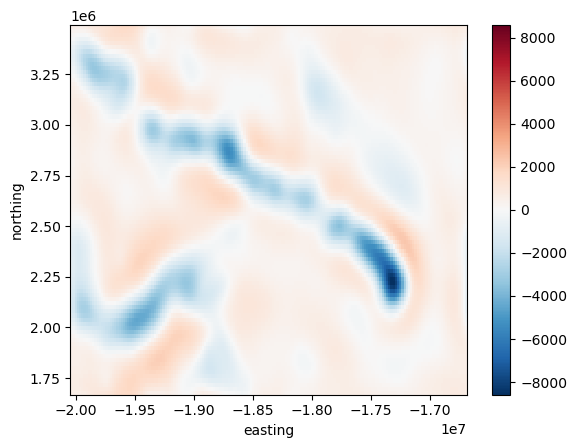

In [18]:
flexura = xrft.ifft(
    filtro_flexura(
        topografia_ft.freq_easting, 
        topografia_ft.freq_northing, 
        Te=20e3,
    ) * topografia_ft, 
    true_amplitude=True, 
    true_phase=True,
).real
flexura.plot()

In [19]:
disturbio_ft = xrft.fft(hm.gaussian_highpass(disturbio * 1e-5, wavelength=1e6), true_amplitude=True, true_phase=True)
disturbio_ft = xrft.fft(disturbio * 1e-5, true_amplitude=True, true_phase=True)

/home/leo/bin/conda/envs/aula2023/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [20]:
filtro_grav_topo = disturbio_ft / topografia_ft
k = np.sqrt(topografia_ft.freq_northing**2 + topografia_ft.freq_easting**2)

Text(0, 0.5, 'Número de onda (1/m)')

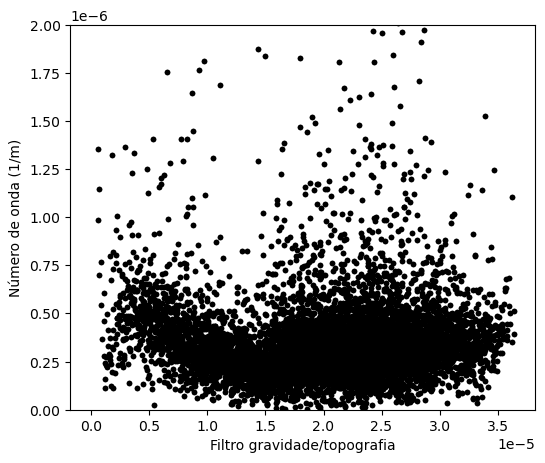

In [21]:
plt.figure(figsize=(6, 5))
plt.plot(k.values.ravel(), np.abs(filtro_grav_topo).values.ravel(), ".k")
plt.ylim(0, 0.000002)
plt.xlabel("Filtro gravidade/topografia")
plt.ylabel("Número de onda (1/m)")

In [22]:
def filtro_flexura_grav(
    kx, ky, Te, distancia, espessura_crosta,
    densidade_crosta=2800, densidade_agua=1000, densidade_manto=3300, 
    young=6.5e10, poisson=0.25, gravidade=9.8,
):
    """
    Calcula o filtro para prever grav causado pela flexura.
    """
    G = 6.67430e-11
    D = young * Te ** 3 / (
        12 * (1 - poisson ** 2)
    )
    k = np.sqrt(ky**2 + kx**2)
    filtro = (
        2 * np.pi * G * (densidade_crosta - densidade_agua)
        * np.exp(-2 * np.pi * k * distancia) * (
            1 - 1 / (
                1 + (D * (2 * np.pi * k)**4)
                / (gravidade * (densidade_manto - densidade_crosta))
            ) * np.exp(-2 * np.pi * k * espessura_crosta)
        )
    )
    return filtro

In [23]:
filtro_grav_topo_pred = filtro_flexura_grav(    
    topografia_ft.freq_easting, 
    topografia_ft.freq_northing, 
    Te=30e3,
    distancia=10e3 - s,
    espessura_crosta=6e3,
)

Text(0, 0.5, 'Número de onda (1/m)')

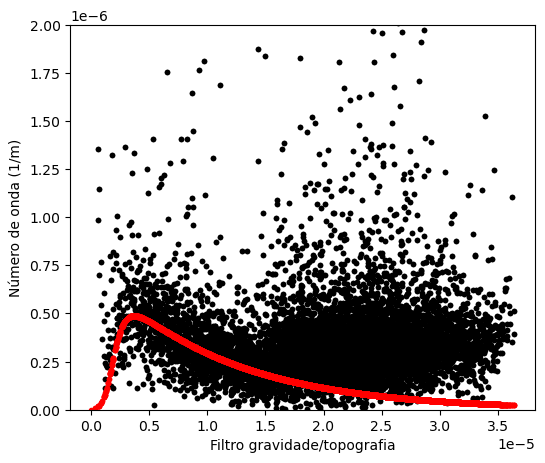

In [24]:
plt.figure(figsize=(6, 5))
plt.plot(k.values.ravel(), np.abs(filtro_grav_topo).values.ravel(), ".k")
plt.plot(k.values.ravel(), np.abs(filtro_grav_topo_pred).values.ravel(), ".r")
plt.ylim(0, 0.000002)
plt.xlabel("Filtro gravidade/topografia")
plt.ylabel("Número de onda (1/m)")